In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/hello-1/dex_imdb_wiki.caffemodel.pt
/kaggle/input/hello-1/pretrained.pkl


# Khai báo các thư viện cần thiết

In [2]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import warnings
import pandas as pd
import numpy as np
from PIL import Image
import requests
import zipfile
warnings.filterwarnings("ignore")


In [3]:
# Function to download and extract FG-NET dataset
def download_fgnet(destination_folder):
    url = "http://yanweifu.github.io/FG_NET_data/FGNET.zip"
    local_zip = os.path.join(destination_folder, "FGNET.zip")

    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    if not os.path.exists(local_zip):
        print("Downloading FG-NET dataset...")
        response = requests.get(url, stream=True)
        with open(local_zip, 'wb') as file:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    file.write(chunk)
        print("Download completed.")

    # Extract the dataset
    with zipfile.ZipFile(local_zip, 'r') as zip_ref:
        zip_ref.extractall(destination_folder)
        print("Dataset extracted.")

# Specify destination folder
data_dir = "path/to/fgnet"
download_fgnet(data_dir)

Download completed.
Dataset extracted.


# Lấy dữ liệu 

In [4]:
import os
import numpy as np
import pandas as pd
from PIL import Image

# Định nghĩa đường dẫn thư mục
images_dir = "path/to/fgnet/FGNET/images"  # Thư mục chứa ảnh
points_dir = "path/to/fgnet/FGNET/points"  # Thư mục chứa file .pts

# Hàm đọc dữ liệu từ tệp .pts
def read_pts_file(pts_file_path):
    points = []
    with open(pts_file_path, "r") as f:
        lines = f.readlines()
        for line in lines:
            try:
                # Chỉ lấy các dòng chứa tọa độ (loại bỏ tiêu đề hoặc dòng trống)
                if line.strip() and not line.startswith(("#", "version", "n_points")):
                    x, y = map(float, line.strip().split())
                    points.append((x, y))
            except ValueError:
                continue
    return points

# Hàm xử lý ảnh và lưu ID, Age, Points
def process_images_and_points(images_dir, points_dir):
    data_info = []
    for file_name in os.listdir(images_dir):
        if file_name.endswith(".jpg") or file_name.endswith(".JPG"):
            file_path = os.path.join(images_dir, file_name)
            # Lấy ID từ tên file (ví dụ: 048A02.jpg -> ID là 048a02)
            id_code = file_name.split('.')[0].lower()  # Chuyển về chữ thường
            # Lấy Age từ phần ký tự sau ID (nếu có logic cụ thể hơn, điều chỉnh tại đây)
            age = file_name[len(id_code):].split('.')[0]
            try:
                # Đọc ảnh và chuyển sang NumPy array
                image = Image.open(file_path).convert("RGB")
                image_array = np.array(image)
                # Đường dẫn tệp .pts tương ứng
                pts_file_path = os.path.join(points_dir, f"{id_code}.pts")
                # Đọc dữ liệu từ tệp .pts
                points = read_pts_file(pts_file_path) if os.path.exists(pts_file_path) else None
                # Lưu thông tin ID, Age, Image và Points
                data_info.append({"ID": id_code, "Age": age, "Image": image_array, "Points": points})
            except Exception as e:
                print(f"Error processing file {file_name}: {e}")
    # Trả về DataFrame chứa thông tin
    return pd.DataFrame(data_info)

# Gọi hàm xử lý ảnh và points
images_and_points_df = process_images_and_points(images_dir, points_dir)

# Hiển thị kết quả
print(images_and_points_df.head())

# Tùy chọn: Lưu DataFrame vào file CSV (lưu ID, Age, và Points; không lưu NumPy array vì CSV không hỗ trợ)
output_csv_path = "fgnet_image_summary_with_points.csv"
images_and_points_df[["ID", "Age", "Points"]].to_csv(output_csv_path, index=False)
print(f"Summary (ID, Age, Points) saved to {output_csv_path}")


       ID Age                                              Image  \
0  041a02      [[[143, 118, 96], [139, 114, 92], [136, 111, 8...   
1  028a46      [[[64, 69, 73], [65, 70, 74], [64, 69, 75], [6...   
2  066a08      [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
3  001a40      [[[91, 64, 53], [93, 69, 57], [99, 75, 65], [1...   
4  050a18      [[[26, 24, 25], [25, 23, 24], [23, 21, 22], [2...   

                                              Points  
0  [(69.3636, 313.366), (80.9351, 350.009), (96.4...  
1  [(45.0707, 224.992), (43.3033, 259.415), (43.3...  
2  [(57.3518, 290.09), (64.45, 328.539), (74.0668...  
3  [(59.3742, 246.555), (55.4613, 279.81), (60.13...  
4  [(31.1234, 211.536), (23.6676, 256.179), (20.8...  
Summary (ID, Age, Points) saved to fgnet_image_summary_with_points.csv


In [5]:
print("Số lượng data dữ liệu gốc: ", len(images_and_points_df))

Số lượng data dữ liệu gốc:  1002


In [6]:
def extract_age_and_update_id(dataframe):
    """Hàm lấy Age từ ID và thêm Age vào sau chữ 'a' trong ID."""
    # Bước 1: Tách Age từ ID
    dataframe['Age'] = dataframe['ID'].str[4:]  # Lấy tất cả ký tự sau chữ 'a'
    
    # Bước 2: Cập nhật lại ID
    dataframe['ID'] = dataframe['ID'].str[:4]  # Ghép lại ID và Age
    return dataframe

# Áp dụng hàm vào DataFrame
images_and_points_df = extract_age_and_update_id(images_and_points_df)

# Hiển thị DataFrame sau khi cập nhật
print(images_and_points_df.head())

# Lưu lại DataFrame sau khi cập nhật
images_and_points_df[["ID", "Age", "Points"]].to_csv("fgnet_image_summary_with_updated_id.csv", index=False)
print("Updated DataFrame saved to fgnet_image_summary_with_updated_id.csv")


     ID Age                                              Image  \
0  041a  02  [[[143, 118, 96], [139, 114, 92], [136, 111, 8...   
1  028a  46  [[[64, 69, 73], [65, 70, 74], [64, 69, 75], [6...   
2  066a  08  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...   
3  001a  40  [[[91, 64, 53], [93, 69, 57], [99, 75, 65], [1...   
4  050a  18  [[[26, 24, 25], [25, 23, 24], [23, 21, 22], [2...   

                                              Points  
0  [(69.3636, 313.366), (80.9351, 350.009), (96.4...  
1  [(45.0707, 224.992), (43.3033, 259.415), (43.3...  
2  [(57.3518, 290.09), (64.45, 328.539), (74.0668...  
3  [(59.3742, 246.555), (55.4613, 279.81), (60.13...  
4  [(31.1234, 211.536), (23.6676, 256.179), (20.8...  
Updated DataFrame saved to fgnet_image_summary_with_updated_id.csv


In [7]:
# Lọc các dòng có ID là '001A'
id_to_filter = "001a"
filtered_rows = images_and_points_df[images_and_points_df["ID"] == id_to_filter]

# Hiển thị kết quả
# print(f"Thông tin các dòng có ID '{id_to_filter}':")
# print(filtered_rows)

# Nếu muốn hiển thị số lượng kết quả
print(f"Số lượng dòng có ID '{id_to_filter}': {len(filtered_rows)}")


Số lượng dòng có ID '001a': 15


# Tiền xử lý dữ liệu

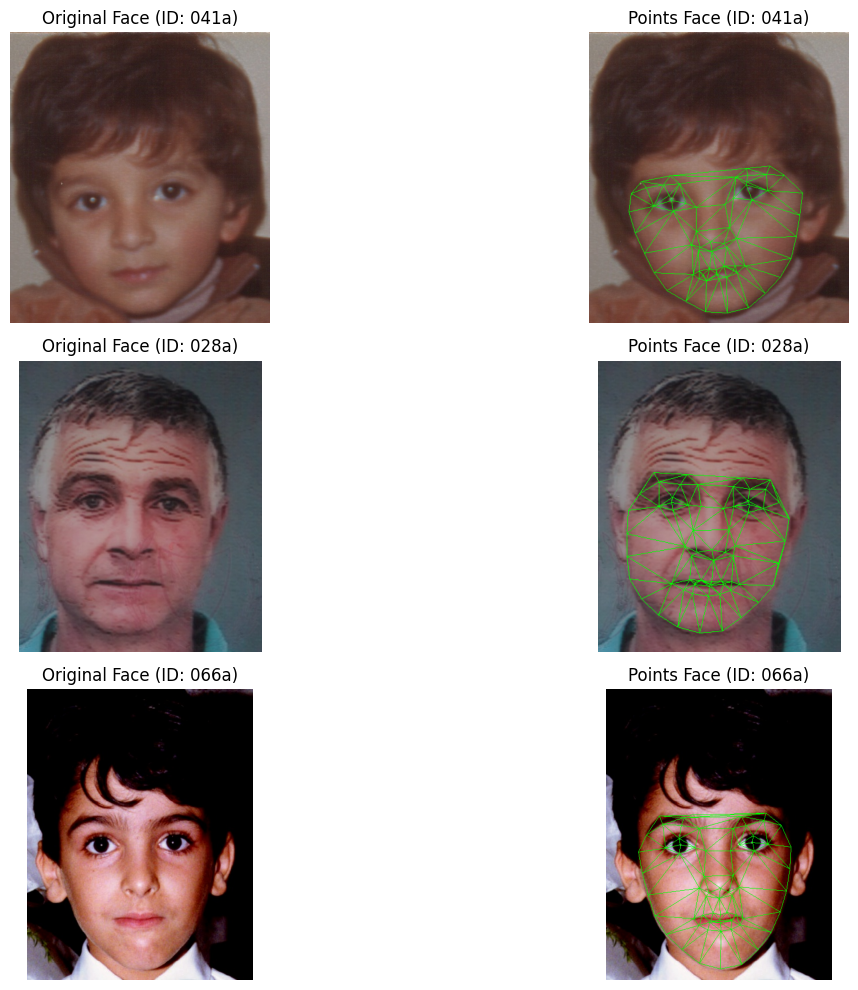

In [8]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import scipy.spatial

# Hàm căn chỉnh khuôn mặt dựa trên Delaunay Triangulation
def align_face_using_points_delaunay(image, points):
    # Chọn các điểm mốc mắt trái, mắt phải, mũi
    left_eye = np.mean(points[36:42], axis=0).astype("int")  # Trung bình điểm mốc mắt trái
    right_eye = np.mean(points[42:48], axis=0).astype("int")  # Trung bình điểm mốc mắt phải
    nose = points[30].astype("int")  # Điểm mốc mũi

    # Delaunay Triangulation
    hull = points  # Lấy tất cả các điểm mốc
    tri = scipy.spatial.Delaunay(hull)  # Triangulation

    # Vẽ các tam giác để kiểm tra
    img_tri = image.copy()
    for simplex in tri.simplices:
        pts = [tuple(hull[simplex[i]]) for i in range(3)]
        cv2.polylines(img_tri, [np.array(pts, dtype=np.int32)], isClosed=True, color=(0, 255, 0), thickness=1)

    return img_tri

# Hàm xử lý tất cả các khuôn mặt và lưu vào DataFrame
def process_and_align_faces_delaunay(dataframe):
    aligned_data = []

    for i in range(len(dataframe)):
        row = dataframe.iloc[i]
        image = np.array(row['Image'], dtype=np.uint8)
        points = np.array(row['Points'], dtype=np.float32)  # Chuyển Points sang NumPy array

        # Căn chỉnh khuôn mặt
        aligned_face = align_face_using_points_delaunay(image, points)
        aligned_data.append({"ID": row["ID"], "Age": row["Age"], "AlignedImage": aligned_face})

    # Tạo DataFrame mới
    aligned_df = pd.DataFrame(aligned_data)
    return aligned_df

# Áp dụng hàm căn chỉnh khuôn mặt
images_face_aligned = process_and_align_faces_delaunay(images_and_points_df)

# Hiển thị ba ảnh gốc và căn chỉnh đầu tiên
plt.figure(figsize=(15, 10))
for i in range(min(3, len(images_face_aligned))):
    # Ảnh gốc
    original_image = np.array(images_and_points_df.iloc[i]['Image'], dtype=np.uint8)
    plt.subplot(3, 2, 2 * i + 1)
    plt.imshow(original_image)
    plt.title(f"Original Face (ID: {images_and_points_df.iloc[i]['ID']})")
    plt.axis("off")

    # Ảnh đã căn chỉnh
    aligned_image = images_face_aligned.iloc[i]['AlignedImage']
    plt.subplot(3, 2, 2 * i + 2)
    plt.imshow(aligned_image)
    plt.title(f"Points Face (ID: {images_face_aligned.iloc[i]['ID']})")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Lưu DataFrame mới vào file CSV (chỉ lưu ID và Age để tránh lỗi với NumPy arrays)
# output_csv_path = "images_face_aligned.csv"
# images_face_aligned[["ID", "Age"]].to_csv(output_csv_path, index=False)
# print(f"Aligned face data saved to {output_csv_path}")


In [9]:
!pip install dlib


# Căn chỉnh khuôn mặt

In [10]:
# Cài đặt Git (nếu chưa có)
!apt-get install git

# Clone kho lưu trữ GitHub
!git clone https://github.com/italojs/facial-landmarks-recognition.git




git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 132 not upgraded.
Cloning into 'facial-landmarks-recognition'...
remote: Enumerating objects: 8, done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 8 (from 1)
Receiving objects: 100% (8/8), 68.98 MiB | 37.17 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [11]:
# import cv2
# import dlib


# # Đường dẫn tới mô hình shape predictor (phải tải mô hình shape_predictor_68_face_landmarks.dat)
# predictor_path = "/kaggle/working/facial-landmarks-recognition/shape_predictor_68_face_landmarks.dat"  # Đường dẫn chính xác

# # Khởi tạo các đối tượng dlib
# detector = dlib.get_frontal_face_detector()
# predictor = dlib.shape_predictor(predictor_path)

# # Đọc ảnh đầu vào
# image = cv2.imread('/path/to/fgnet/FGNET/images/048A16.JPG')
# if image is None:
#     print("Không thể đọc ảnh từ đường dẫn này.")
# else:
#     print("Ảnh đã được đọc thành công.")


# # Chuyển ảnh sang grayscale
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# # Phát hiện khuôn mặt trong ảnh
# faces = detector(gray)

# # Kiểm tra nếu có khuôn mặt
# for face in faces:
#     landmarks = predictor(gray, face)  # Nhận diện các điểm đặc trưng khuôn mặt

#     # Tạo một mảng các điểm đặc trưng
#     points = []
#     for n in range(68):  # Dlib 68 landmarks
#         x = landmarks.part(n).x
#         y = landmarks.part(n).y
#         points.append((x, y))

#     # Chuyển đổi sang numpy array
#     points = np.array(points)

#     # Căn chỉnh ảnh: Dịch chuyển các điểm đặc trưng về một vị trí chuẩn
#     # Tạo một số điểm chuẩn (ví dụ, mắt trái và mắt phải)
#     left_eye = points[36]  # Điểm mắt trái
#     right_eye = points[45]  # Điểm mắt phải

#     # Tính toán góc giữa mắt trái và mắt phải
#     eye_center = ((left_eye[0] + right_eye[0]) // 2, (left_eye[1] + right_eye[1]) // 2)
#     dx = right_eye[0] - left_eye[0]
#     dy = right_eye[1] - left_eye[1]
#     angle = np.degrees(np.arctan2(dy, dx))

#     # Căn chỉnh ảnh (quay ảnh sao cho mắt ngang)
#     M = cv2.getRotationMatrix2D(eye_center, angle, 1)
#     aligned_image = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))

#     # Hiển thị ảnh căn chỉnh
#     cv2.imshow('Aligned Face', aligned_image)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()



# Điều chỉnh màu

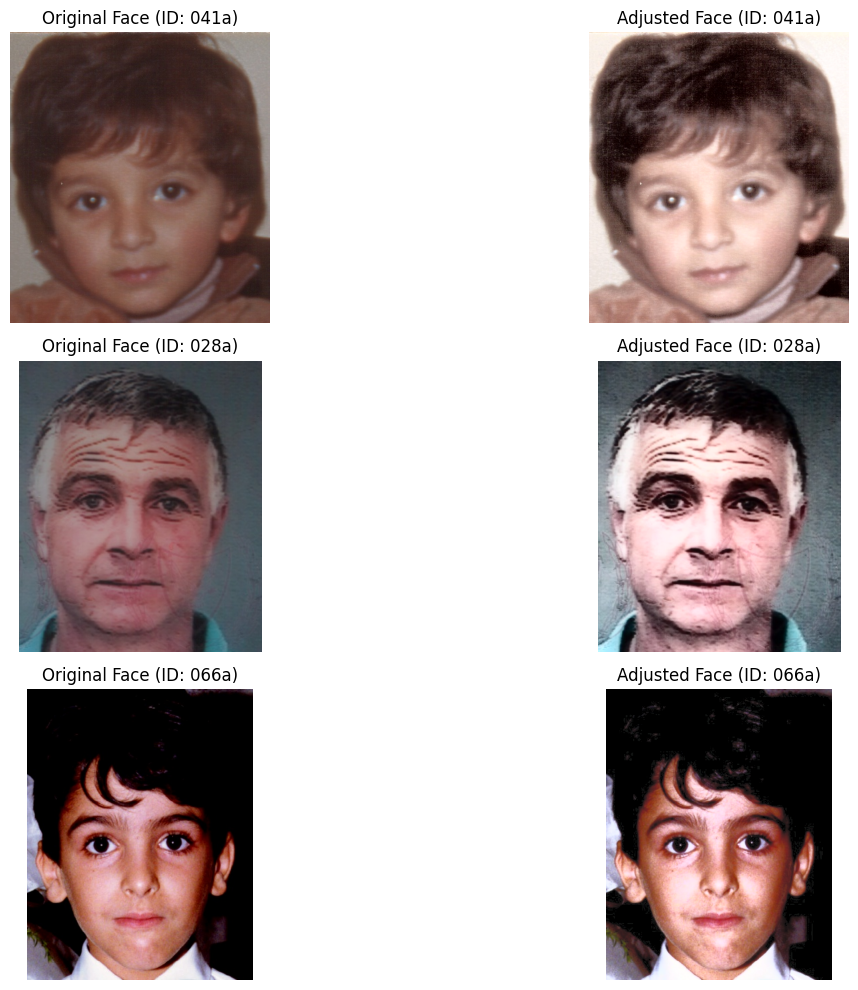

In [12]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Hàm điều chỉnh phân phối màu (Histogram Equalization)
def adjust_color_distribution(image):
    # Chuyển ảnh sang không gian màu YUV
    yuv_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)

    # Cân bằng histogram của kênh Y (luminance)
    yuv_image[:, :, 0] = cv2.equalizeHist(yuv_image[:, :, 0])

    # Chuyển lại ảnh sang không gian màu RGB
    equalized_image = cv2.cvtColor(yuv_image, cv2.COLOR_YUV2RGB)

    return equalized_image

# Hàm xử lý tất cả các khuôn mặt và lưu vào DataFrame
def process_and_adjust_faces(dataframe):
    adjusted_data = []

    for i in range(len(dataframe)):
        row = dataframe.iloc[i]
        image = np.array(row['Image'], dtype=np.uint8)
        points = np.array(row['Points'], dtype=np.float32)  # Chuyển Points sang NumPy array

        # Điều chỉnh phân phối màu cho ảnh
        adjusted_face = adjust_color_distribution(image)
        adjusted_data.append({"ID": row["ID"], "Age": row["Age"], "AdjustedImage": adjusted_face, "Points": points})

    # Tạo DataFrame mới
    adjusted_df = pd.DataFrame(adjusted_data)
    return adjusted_df

# Áp dụng hàm điều chỉnh phân phối màu cho ảnh
images_and_points_adjusted = process_and_adjust_faces(images_and_points_df)

# Hiển thị ba ảnh gốc và đã điều chỉnh phân phối màu
plt.figure(figsize=(15, 10))
for i in range(min(3, len(images_and_points_adjusted))):
    # Ảnh gốc
    original_image = np.array(images_and_points_df.iloc[i]['Image'], dtype=np.uint8)
    plt.subplot(3, 2, 2 * i + 1)
    plt.imshow(original_image)
    plt.title(f"Original Face (ID: {images_and_points_df.iloc[i]['ID']})")
    plt.axis("off")

    # Ảnh đã điều chỉnh phân phối màu
    adjusted_image = images_and_points_adjusted.iloc[i]['AdjustedImage']
    plt.subplot(3, 2, 2 * i + 2)
    plt.imshow(adjusted_image)
    plt.title(f"Adjusted Face (ID: {images_and_points_adjusted.iloc[i]['ID']})")
    plt.axis("off")

plt.tight_layout()
plt.show()

# # Lưu DataFrame mới vào file CSV (chỉ lưu ID, Age, và các điểm mốc)
# output_csv_path = "images_and_points_adjusted.csv"
# images_and_points_adjusted[["ID", "Age", "Points"]].to_csv(output_csv_path, index=False)
# print(f"Adjusted face data saved to {output_csv_path}")


# Noise reduce

In [13]:
# Hàm giảm nhiễu sử dụng Non-Local Means Denoising
def denoise_image(image):
    # Chuyển ảnh sang định dạng màu xám (grayscale) để giảm nhiễu
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Áp dụng phương pháp Non-Local Means Denoising
    denoised_image = cv2.fastNlMeansDenoising(gray, None, 10, 7, 21)

    # Chuyển ảnh trở lại màu RGB
    denoised_image = cv2.cvtColor(denoised_image, cv2.COLOR_GRAY2RGB)
    
    return denoised_image

# Hàm xử lý tất cả các khuôn mặt và giảm nhiễu
def process_and_denoise_faces(dataframe):
    denoised_data = []

    for i in range(len(dataframe)):
        row = dataframe.iloc[i]
        image = np.array(row['AdjustedImage'], dtype=np.uint8)

        # Giảm nhiễu cho ảnh
        denoised_face = denoise_image(image)
        denoised_data.append({"ID": row["ID"], "Age": row["Age"], "DenoisedImage": denoised_face})

    # Tạo DataFrame mới
    denoised_df = pd.DataFrame(denoised_data)
    return denoised_df

# Áp dụng hàm giảm nhiễu cho ảnh
images_and_points_denoised = process_and_denoise_faces(images_and_points_adjusted)





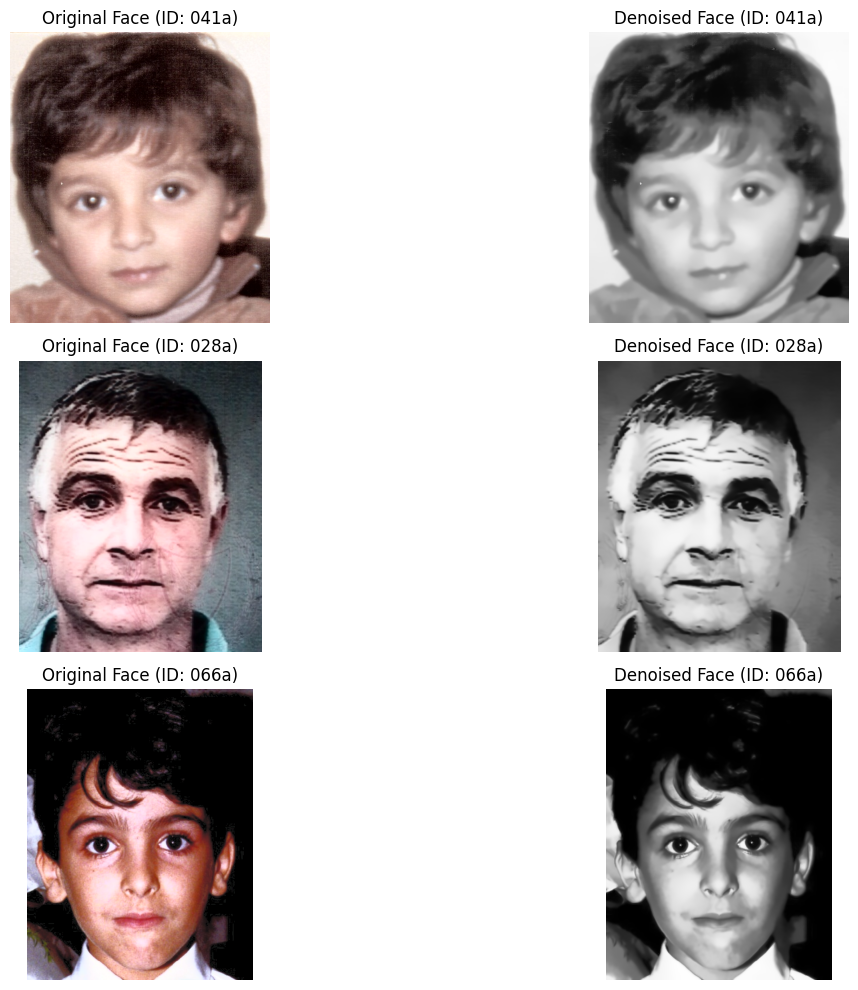

In [14]:
# Hiển thị ba ảnh gốc và ảnh đã giảm nhiễu
plt.figure(figsize=(15, 10))
for i in range(min(3, len(images_and_points_denoised))):
    # Ảnh gốc
    original_image = np.array(images_and_points_adjusted.iloc[i]['AdjustedImage'], dtype=np.uint8)
    plt.subplot(3, 2, 2 * i + 1)
    plt.imshow(original_image)
    plt.title(f"Original Face (ID: {images_and_points_adjusted.iloc[i]['ID']})")
    plt.axis("off")

    # Ảnh đã giảm nhiễu
    denoised_image = images_and_points_denoised.iloc[i]['DenoisedImage']
    plt.subplot(3, 2, 2 * i + 2)
    plt.imshow(denoised_image)
    plt.title(f"Denoised Face (ID: {images_and_points_denoised.iloc[i]['ID']})")
    plt.axis("off")

plt.tight_layout()
plt.show()

# CUSP

In [15]:
len(images_and_points_denoised)

1002

In [16]:
!git clone https://github.com/guillermogotre/cusp-pytorch/
%cd cusp-pytorch

Cloning into 'cusp-pytorch'...
remote: Enumerating objects: 191, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 191 (delta 2), reused 2 (delta 2), pack-reused 187 (from 2)
Receiving objects: 100% (191/191), 9.44 MiB | 34.42 MiB/s, done.
Resolving deltas: 100% (85/85), done.
/kaggle/working/cusp-pytorch


In [17]:
import os
import time
import pickle

import torch
import torch.nn.functional as F

import PIL.Image
import numpy as np
import matplotlib.pyplot as plt

# Custom modules
from training.networks import VGG, module_no_grad
import legacy
from torch_utils import misc
import dnnlib

In [18]:
FFHQ_LS_KEY = "lats"  # Mô hình được huấn luyện trên tập dữ liệu LATS
FFHQ_RR_KEY = "hrfae" # Mô hình được huấn luyện trên tập dữ liệu HRFAE

# Lựa chọn một mô hình từ các khóa trên
KEY = FFHQ_RR_KEY # [HRFAE_KEY hoặc LATS_KEY]
# KEY = FFHQ_LS_KEY # [HRFAE_KEY hoặc LATS_KEY]

# Cấu hình và ID Google Drive
vgg_path_gdrive_id = '1a0jghZx44uC_kIIvD-UEcNp4Xz8Bpso1'
configs = {
    # Cấu hình cho mô hình LATS
    FFHQ_LS_KEY: dict(
        gdrive_id="1sWSH3tHgm9DkHrc19hoEMrR-KQgnaFuw",  # ID trên Google Drive của mô hình LATS
        side=256,  # Kích thước ảnh đầu vào (256x256)
        classes=(1,8)  # Khoảng nhãn độ tuổi (1-8)
    ),
    # Cấu hình cho mô hình HRFAE
    FFHQ_RR_KEY: dict(
        gdrive_id="17BOTEa6z3r6JFVs1KDutDxWEkTWbzaeD",  # ID trên Google Drive của mô hình HRFAE
        side=224,  # Kích thước ảnh đầu vào (224x224)
        classes=(20,65)  # Khoảng nhãn độ tuổi (20-65)
    )
}

# Thiết lập thiết bị tính toán sử dụng CUDA (GPU)
device = torch.device('cuda', 0)

# Đường dẫn đến thư mục chứa ảnh mẫu
sample_images_path = "sample_images"  # Các ảnh mẫu được lấy từ bộ dữ liệu FFHQ

# ID mô hình trên Google Drive
model_id = configs[KEY]['gdrive_id']

# Kích thước của ảnh đầu vào
img_side = configs[KEY]['side']

# Phạm vi nhãn để sinh dữ liệu ví dụ (khoảng độ tuổi)
data_labels_range = configs[KEY]['classes']

# Đọc tên các tập tin ảnh trong thư mục ảnh mẫu
filenames_batch = [
    os.path.join(sample_images_path, f)  # Đường dẫn đầy đủ của tệp ảnh
    for f in next(iter(os.walk(sample_images_path)))[2]  # Lặp qua tất cả các tập tin trong thư mục
    if f[-4:] == '.png'  # Chỉ chọn các tệp ảnh có phần mở rộng là .png
]

In [19]:
# Hàm download_gdrive_id dùng để tải một tệp từ Google Drive về máy local
# Tham số đầu vào:
# - gid: ID của tệp trên Google Drive
# - file_path: Đường dẫn nơi tệp sẽ được lưu trên máy
def download_gdrive_id(gid, file_path):
    begin = time.time()  # Ghi lại thời gian bắt đầu quá trình tải
    # Tạo một đối tượng tệp từ Google Drive dựa trên ID
    gfile = drive.CreateFile(dict(id=gid))
    # Tải nội dung tệp về máy và lưu vào đường dẫn file_path
    gfile.GetContentFile(file_path)

    # In ra thông báo quá trình tải thành công với thời gian tải
    print(f"File {gfile['title']} ({gid}) downloaded to {file_path} in {time.time()-begin} seconds")

# Đường dẫn đích để lưu các tệp đã tải
weights_path = "pretrained.pkl"  # Đường dẫn lưu tệp trọng số của mô hình đã huấn luyện
vgg_path = "dex_imdb_wiki.caffemodel.pt"  # Đường dẫn lưu tệp mô hình VGG đã huấn luyệ

In [20]:
# Hàm load_model dùng để tải mô hình đã huấn luyện và mô hình phân loại VGG
# Tham số đầu vào:
# - model_path: Đường dẫn tới tệp chứa trọng số mô hình
# - vgg_path: Đường dẫn tới tệp chứa mô hình phân loại VGG đã huấn luyện
# - device: Thiết bị (CPU hoặc GPU) mà mô hình sẽ chạy trên đó
def load_model(model_path, vgg_path, device):
    # Mở tệp mô hình chứa trọng số đã huấn luyện
    with open("/kaggle/input/hello-1/"+model_path, 'rb') as f:
        contents = legacy.load_network_pkl(f)  # Tải trọng số và mã nguồn được pickle

    # Lấy mô hình với trung bình di động lũy thừa (exponential moving average)
    G_ema = contents['G_ema']

    # Tải mô hình phân loại DEX VGG
    vgg = VGG()  # Tạo đối tượng mô hình VGG
    vgg_state_dict = torch.load("/kaggle/input/hello-1/"+vgg_path)  # Tải trạng thái (trọng số) của mô hình VGG từ tệp
    # Đổi dấu '-' thành '_' trong tên các khóa của state_dict để khớp với các tên trong mô hình
    vgg_state_dict = {k.replace('-', '_'): v for k, v in vgg_state_dict.items()}
    vgg.load_state_dict(vgg_state_dict)  # Tải trạng thái trọng số vào mô hình VGG
    module_no_grad(vgg)  # Đặt chế độ no_grad cho mô hình VGG để không tính gradient

    # Gán mô hình phân loại VGG cho bộ phân loại của mô hình G_ema
    G_ema.skip_grad_blur.model.classifier = vgg
    # Đưa mô hình G_ema lên thiết bị (CPU/GPU), chuyển về chế độ eval (chế độ inference) và tắt yêu cầu tính gradient
    G_ema = G_ema.to(device).eval().requires_grad_(False)
    # G_ema = G_ema.eval().requires_grad_(False)

    # Trả về mô hình G_ema đã được cài đặt và chuyển vào thiết bị
    return G_ema

 # Chuyển sang CPU nếu không có GPU
# device = torch.device('cpu') 
# Tải mô hình với trọng số và VGG classifier
G_ema = load_model(
    weights_path,  # Đường dẫn tới trọng số của mô hình đã huấn luyện
    vgg_path,      # Đường dẫn tới mô hình phân loại VGG đã huấn luyện
    device)        # Thiết bị mà mô hình sẽ chạy trên (CPU hoặc GPU)

In [21]:
images_and_points_adjusted.head()

,ID,Age,AdjustedImage,Points
0,041a,02,"[[[246, 220, 199], [242, 216, 195], [237, 211,...","[[69.3636, 313.366], [80.9351, 350.009], [96.4..."
1,028a,46,"[[[52, 59, 61], [55, 62, 64], [52, 58, 63], [4...","[[45.0707, 224.992], [43.3033, 259.415], [43.3..."
2,066a,08,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...","[[57.3518, 290.09], [64.45, 328.539], [74.0668..."
3,001a,40,"[[[119, 91, 80], [120, 96, 84], [126, 102, 92]...","[[59.3742, 246.555], [55.4613, 279.81], [60.13..."
4,050a,18,"[[[9, 7, 8], [5, 3, 4], [2, 0, 1], [1, 0, 0], ...","[[31.1234, 211.536], [23.6676, 256.179], [20.8..."


In [22]:
import pandas as pd

# Giả sử bạn đã có DataFrame images_and_points_adjusted

# Hàm loại bỏ ký tự không phải số và chuyển thành số
def clean_age(age_str):
    # Loại bỏ các ký tự không phải là số (chỉ giữ lại chữ số)
    cleaned_age = ''.join([char for char in age_str if char.isdigit()])
    return int(cleaned_age)  # Chuyển về kiểu số nguyên

# Áp dụng hàm clean_age cho cột Age
images_and_points_adjusted['Age'] = images_and_points_adjusted['Age'].apply(clean_age)

# Sắp xếp DataFrame theo ID (theo thứ tự chuỗi) và Age (theo thứ tự số)
images_and_points_adjusted_sorted = images_and_points_adjusted.sort_values(by=['ID', 'Age'])

# # Hiển thị DataFrame đã sắp xếp
# import ace_tools as tools; tools.display_dataframe_to_user(name="Sorted Images and Points", dataframe=images_and_points_adjusted_sorted)

# Kiểm tra kết quả
print(images_and_points_adjusted_sorted.head())


       ID  Age                                      AdjustedImage  \
959  001a    2  [[[69, 69, 69], [71, 71, 71], [71, 71, 71], [6...   
349  001a    5  [[[99, 99, 99], [105, 105, 105], [112, 112, 11...   
622  001a    8  [[[144, 144, 144], [144, 144, 144], [144, 144,...   
350  001a   10  [[[141, 141, 141], [139, 139, 139], [136, 136,...   
639  001a   14  [[[227, 136, 144], [231, 140, 148], [232, 141,...   

                                                Points  
959  [[74.9337, 200.858], [83.8168, 220.22], [93.44...  
349  [[115.947, 221.239], [121.382, 250.566], [130....  
622  [[90.6973, 254.402], [97.5994, 288.41], [105.5...  
350  [[68.1974, 234.479], [69.4503, 262.977], [73.3...  
639  [[57.678, 212.006], [64.3484, 239.792], [72.59...  


In [23]:
def run_model(G, img, label, global_blur_val=None, mask_blur_val=None, return_msk=False):
    # Chuyển nhãn (label) thành định dạng One Hot Encoding
    cls = torch.nn.functional.one_hot(
        torch.tensor(label),  # Chuyển nhãn thành tensor
        num_classes=G.attr_map.fc0.init_args[0]  # Số lớp trong bản đồ thuộc tính của mô hình
    ).to(img.device)  # Đưa tensor nhãn lên cùng thiết bị với ảnh (img)

    # Mã hóa nội dung (Content encoder)
    _, c_out_skip = G.content_enc(img)  # Mã hóa ảnh để lấy đặc trưng nội dung (content) và skip connection

    # Mã hóa phong cách (Style encoder)
    s_out = G.style_enc(img)[0].mean((2, 3))  # Mã hóa ảnh để lấy đặc trưng phong cách (style), tính trung bình theo chiều không gian (2,3)

    # Cài đặt giá trị truncation để kiểm soát tính ngẫu nhiên trong phong cách
    truncation_psi = 1  # Hệ số truncation cho độ ngẫu nhiên của phong cách
    truncation_cutoff = None  # Không cắt giảm giá trị truncation
    s_out = G.style_map(s_out, None, truncation_psi, truncation_cutoff)  # Map đặc trưng phong cách với hệ số truncation

    # Ánh xạ tuổi (age mapping)
    a_out = G.attr_map(cls.to(s_out.device), None, truncation_psi, truncation_cutoff)  # Map đặc trưng tuổi từ nhãn (label)

    # Kết hợp ánh xạ phong cách và tuổi vào các module điều biến trọng số (weight demodulation)
    w = G.__interleave_attr_style__(a_out, s_out)  # Kết hợp phong cách và thuộc tính tuổi để điều chỉnh trọng số

    # Làm mờ toàn cục (Global blur)
    for i, (f, _) in enumerate(zip(G.skip_transf, c_out_skip)):  # Duyệt qua từng layer với skip connection
        if f is not None:
            # Làm mờ toàn cục cho từng skip connection với giá trị làm mờ được cung cấp
            c_out_skip[i] = G._batch_blur(c_out_skip[i], blur_val=global_blur_val)

    # Làm mờ mặt nạ (Masked blur)
    cam = G.skip_grad_blur(img.float())  # Tính toán mặt nạ làm mờ (cam) cho ảnh gốc
    msk = cam  # Gán mặt nạ vào biến msk

#     print(cam)  # Kiểm tra xem cam có phải là None không

    for i, (f, c) in enumerate(zip(G.skip_transf, c_out_skip)):
        if f is not None:
            im_size = c.size(-1)  # Kích thước hình ảnh tại layer hiện tại
            # Làm mờ content với giá trị blur cho mask
            blur_c = G._batch_blur(c, blur_val=mask_blur_val)
            if msk.size(2) != im_size:  # Nếu kích thước mặt nạ không khớp với kích thước layer hiện tại
                msk = F.interpolate(msk, size=(im_size, im_size), mode='area')  # Thay đổi kích thước mặt nạ
            # Trộn nội dung với mặt nạ và phần làm mờ
            merged_c = c * msk + blur_c * (1 - msk)
            c_out_skip[i] = merged_c  # Cập nhật skip connection

    # Bộ giải mã ảnh (Decoder)
    img_out = G.image_dec(c_out_skip, w)  # Giải mã ảnh đầu ra từ skip connection và trọng số đã điều biến

    # Nếu trả về mặt nạ, kiểm tra nếu mô hình học mặt nạ thì trả về kèm mặt nạ, nếu không thì trả về None
    if return_msk:
        to_return = (img_out, msk, cam) if G.learn_mask is not None else (img_out, None, None)
    else:
        to_return = img_out  # Nếu không, chỉ trả về ảnh đầu ra

    # Kiểm tra rằng không có gradient nào được tính toán cho các tham số của mô hình G và bộ phân loại của skip_grad_blur
    # assert(all(x.grad is None for x in G.parameters()))
    # assert(all(x.grad is None for x in G.skip_grad_blur.model.get_classifier().parameters()))
    # G.zero_grad()  # Đặt lại gradient của mô hình về 0

    return to_return  # Trả về kết quả cuối cùng

In [24]:
# images_and_points_adjusted_sorted

In [25]:
# import torch
# import numpy as np
# import pandas as pd
# from torchvision import transforms
# import matplotlib.pyplot as plt
# from PIL import Image

# # Kiểm tra xem có GPU (CUDA) không
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Hàm chuẩn hóa ảnh về phạm vi [-1, 1] và chuyển đổi thành tensor
# def convert_images_to_tensor(images_df):
#     transform = transforms.Compose([
#         transforms.ToPILImage(),
#         transforms.Resize((224, 224)),  # Thay đổi kích thước thành (224, 224)
#         transforms.ToTensor(),  # Chuyển đổi thành tensor
#     ])
    
#     images_tensor = []
#     for img in images_df['AdjustedImage']:
#         img_tensor = transform(img)  # Chuyển mỗi ảnh thành tensor
#         images_tensor.append(img_tensor)
    
#     # Chuyển thành tensor với shape (batch_size, channels, height, width)
#     im_in_tensor_FGNET = torch.stack(images_tensor)
    
#     # Chuẩn hóa giá trị pixel vào phạm vi [-1, 1]
#     im_in_tensor_FGNET = im_in_tensor_FGNET / 256 - 1  # Giá trị pixel trong phạm vi [-1, 1]
    
#     return im_in_tensor_FGNET

# # Chuyển các ảnh từ AdjustedImage thành tensor với chuẩn hóa giá trị pixel [0, 1]
# im_in_tensor_FGNET = convert_images_to_tensor(images_and_points_adjusted)

# # Chuyển tensor lên GPU nếu có
# im_in_tensor_FGNET = im_in_tensor_FGNET.to(device)

# # Kiểm tra shape của tensor (sẽ có shape [batch_size, 3, 224, 224])
# print(im_in_tensor_FGNET.shape)

# # Trích xuất tuổi từ cột 'Age'
# ages = images_and_points_adjusted['Age'].values

# # Cập nhật min_age và max_age
# min_age = 10
# max_age = 60

# # Số lượng hình ảnh và số bước chuyển đổi tuổi
# steps =   # Số bước chuyển đổi tuổi
# n_images = im_in_tensor_FGNET.shape[0]

# # Mở rộng tensor theo số bước (steps)
# im_in_tensor_exp = im_in_tensor_FGNET[:, None].expand([n_images, steps, *im_in_tensor_FGNET.shape[1:]]).reshape([-1, *im_in_tensor_FGNET.shape[1:]])

# # Đặt các độ tuổi mục tiêu cho mỗi bước (sử dụng min_age và max_age)
# labels_exp = torch.tensor(np.repeat(np.linspace(min_age, max_age, steps, dtype=int)[:, None], n_images, 1).T.reshape(-1)).to(device)

# # Kích thước batch
# batch_size = 12  # Chia thành các lô nhỏ hơn

# # Giả sử `run_model()` là một hàm đã được định nghĩa và trả về tensor kết quả
# # Chạy mô hình và lấy output
# im_out_tensor_exp = torch.concat([
#     run_model(
#         G_ema,  # Mô hình (cần được định nghĩa)
#         mini_im,
#         mini_label,
#         global_blur_val=0.2,  # Làm mờ toàn cục
#         mask_blur_val=0.8    # Làm mờ theo mặt nạ
#     )
#     for mini_im, mini_label in zip(
#         im_in_tensor_exp.split(batch_size),  # Chia tensor đầu vào thành các lô nhỏ hơn
#         labels_exp.split(batch_size)  # Chia nhãn theo các lô
#     )
# ])

# # Chuyển đổi tensor kết quả thành dạng [batch_size, N_ages, H, W, C]
# im_out_tensor = im_out_tensor_exp.reshape([-1, steps, *im_out_tensor_exp.shape[1:]])

# # Kiểm tra kết quả
# print(f"im_out_tensor shape: {im_out_tensor.shape}")

# # Vẽ ảnh và nhãn tuổi cho mỗi ảnh đầu vào và ảnh đã chuyển đổi
# n_images_to_plot = min(6, im_in_tensor_FGNET.shape[0])  # Chọn số lượng hình ảnh tối đa để vẽ (ở đây là 6)

# # Tạo nhãn tuổi cho mỗi hình ảnh
# labels_exp_plot = np.linspace(min_age, max_age, n_images_to_plot)

# # Đảm bảo rằng kích thước của labels_exp_plot tương thích với số lượng hình ảnh
# labels_exp_plot = np.tile(labels_exp_plot, n_images_to_plot)
# labels_exp_plot = labels_exp_plot.reshape(n_images_to_plot, -1)

# # Hiển thị ảnh và nhãn tuổi
# for im_in, age_labels in zip(im_in_tensor_FGNET[:n_images_to_plot], labels_exp_plot):
#     # Tạo biểu đồ hiển thị ảnh đầu vào
#     fig, ax = plt.subplots(1, 1, figsize=(6, 6))
#     ax.axis('off')
#     ax.imshow(im_in.permute(1, 2, 0).cpu().numpy())  # Chuyển tensor về hình ảnh và hiển thị
#     ax.set_title(f"Age: {age_labels[0]}", fontname='Liberation Serif')  # Hiển thị nhãn tuổi

#     plt.show()  # Hiển thị biểu đồ


# Xử lý dữ liệu và đưa vào dataloader

In [26]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from PIL import Image

# Kiểm tra xem có GPU (CUDA) không
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Định nghĩa các phép biến đổi cho BYOL (bao gồm các phép biến đổi ảnh)
transform_byol = transforms.Compose([
    transforms.RandomResizedCrop(size=128),       # Cắt ngẫu nhiên với kích thước 128x128
    transforms.RandomHorizontalFlip(p=0.5),       # Lật ngang ngẫu nhiên
    transforms.RandomApply([
        transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)  # Điều chỉnh màu sắc ngẫu nhiên
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),            # Chuyển sang thang xám ngẫu nhiên
    transforms.ToTensor(),                        # Chuyển ảnh thành tensor
])

# Lớp Dataset tùy chỉnh để trả về hai phiên bản của cùng một ảnh
class BYOLDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform_view1=None, transform_view2=None):
        self.dataset = datasets.ImageFolder(root_dir)  # Sử dụng ImageFolder để tải ảnh
        self.transform_view1 = transform_view1
        self.transform_view2 = transform_view2
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        img, label = self.dataset[idx]  # Lấy ảnh và nhãn từ dataset
        
        # Tạo hai biến thể của cùng một ảnh (view1 và view2)
        if self.transform_view1:
            img_view1 = self.transform_view1(img)
        if self.transform_view2:
            img_view2 = self.transform_view2(img)
        
        return img_view1, img_view2, label

# Đường dẫn đến thư mục dữ liệu
data_path = 'tensor_FGNET.csv'  # Cập nhật đường dẫn thư mục của bạn

# Tạo dataset cho mô hình BYOL
dataset_byol = BYOLDataset(
    root_dir=data_path,
    transform_view1=transform_byol,  # Áp dụng phép biến đổi cho view1
    transform_view2=transform_byol   # Áp dụng phép biến đổi cho view2
)

# Tách dữ liệu thành train/test (70/30)
train_size = int(0.7 * len(dataset_byol))
test_size = len(dataset_byol) - train_size
train_dataset, test_dataset = random_split(dataset_byol, [train_size, test_size])

# Tạo DataLoader cho train và test
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print("Dữ liệu đã được tải và tách thành train/test với tỷ lệ 70/30.")



FileNotFoundError: [Errno 2] No such file or directory: 'tensor_FGNET.csv'

# Hàm setup các mô hình VIT + BYOL

In [ ]:
from torch import nn
# Setup MLPHead cho VIT để có thể chạy tốt trên mô hình từ transformer encoder

class MLPHead(nn.Module):
    def __init__(self, in_channels, mlp_hidden_size, projection_size):
        super(MLPHead, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(in_channels, mlp_hidden_size),
            nn.BatchNorm1d(mlp_hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(mlp_hidden_size, projection_size)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
# Import thư viện cần thiết từ PyTorch
from torch import nn

# Định nghĩa lớp classifier kế thừa từ nn.Module
class classifier(nn.Module):
    # Khởi tạo mô hình với các tham số đầu vào
    def __init__(self, in_channels, num_classes):
        # Gọi hàm khởi tạo của lớp cha (nn.Module)
        super(classifier, self).__init__()

        # Định nghĩa một mạng phân loại với các lớp Sequential
        self.linear_classifier = nn.Sequential(
            # Thêm lớp BatchNorm1d vào mô hình:
            # BatchNorm1d được sử dụng để chuẩn hóa đầu ra của các lớp fully connected (linear) 
            # với số lượng đầu vào là in_channels. `affine=False` có nghĩa là không học được 
            # các tham số gamma và beta trong quá trình huấn luyện.
            nn.BatchNorm1d(in_channels, affine=False),
            
            # Thêm một lớp Linear (fully connected layer) vào mô hình:
            # Lớp này nhận đầu vào có kích thước `in_channels` và xuất ra một vector có số chiều bằng `num_classes`.
            nn.Linear(in_channels, num_classes)
        )
    
    # Định nghĩa hàm forward của mô hình:
    # Hàm này chỉ ra cách dữ liệu được truyền qua các lớp của mô hình
    def forward(self, x):
        # Truyền đầu vào x qua mô hình (theo thứ tự các lớp đã định nghĩa trong `self.linear_classifier`)
        return self.linear_classifier(x)


# VIT được đưa thành class vựa trên lý thuyết

In [ ]:
# https://github.com/lucidrains/vit-pytorch/blob/main/vit_pytorch/vit.py

import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return x #self.mlp_head(x)

# BYOL

# Import các thư viện cần thiết
import torchvision.models as models  # Import các mô hình có sẵn từ torchvision
import torch  # Import thư viện PyTorch
from einops.layers.torch import Rearrange  # Import lớp Rearrange từ einops, giúp thay đổi kích thước tensor

# Định nghĩa lớp ByolNet kế thừa từ nn.Module
class ByolNet(torch.nn.Module):
    # Khởi tạo mô hình với các tham số đầu vào
    def __init__(self, *args, **kwargs):
        # Gọi hàm khởi tạo của lớp cha (nn.Module)
        super(ByolNet, self).__init__()
        
        # Kiểm tra xem có sử dụng mô hình đã huấn luyện sẵn (pretrained) hay không
        if kwargs['pretrained']:
            # Nếu có pretrained, sử dụng mô hình Vision Transformer (ViT) đã huấn luyện sẵn từ torchvision
            self.byolnet = models.vision_transformer.vit_b_16(image_size=224, weights='DEFAULT')
            # Lấy số lượng đặc trưng đầu vào (in_features) từ lớp đầu ra của mô hình ViT
            in_channels = self.byolnet.heads.head.in_features
        else:
            # Nếu không sử dụng pretrained, tạo một mô hình ViT mới với các tham số đã định nghĩa
            self.byolnet = ViT(image_size = 224,  # Kích thước ảnh đầu vào
                               patch_size = 4,  # Kích thước của các patch trong ViT
                               num_classes = 10,  # Số lớp phân loại
                               dim = 512,  # Số chiều của không gian embedding
                               depth = 6,  # Số lớp transformer
                               heads = 8,  # Số đầu của multi-head attention
                               mlp_dim = 512,  # Kích thước của mạng MLP sau attention
                               dropout = 0.1,  # Tỷ lệ dropout cho các lớp trong transformer
                               emb_dropout = 0.1  # Tỷ lệ dropout cho embedding
            )

            # Lấy số lượng đặc trưng đầu vào từ lớp mlp_head của mô hình ViT
            in_channels = self.byolnet.mlp_head[-1].in_features
            
        # Lưu lại thông tin pretrained (True/False)
        self.pretrained = kwargs['pretrained']

        # Tạo lớp projection cho mô hình BYOL
        # Projection head là một MLP (Multilayer Perceptron) để giảm chiều không gian đặc trưng xuống một kích thước thích hợp
        self.projection = MLPHead(in_channels=in_channels, **kwargs['projection_head'])

    # Định nghĩa hàm forward, là nơi xử lý dữ liệu qua mô hình
    def forward(self, x):
        
        if self.pretrained:
            # Nếu mô hình sử dụng pretrained, tiến hành xử lý đầu vào (chuyển đổi ảnh)
            x = self.byolnet._process_input(x)
            n = x.shape[0]  # Lấy kích thước batch (số mẫu trong batch)

            # Mở rộng "class token" cho toàn bộ batch
            batch_class_token = self.byolnet.class_token.expand(n, -1, -1)
            # Nối "class token" vào đầu tensor dữ liệu đầu vào (giống như ViT)
            x = torch.cat([batch_class_token, x], dim=1)

            # Truyền dữ liệu qua encoder của ViT
            x = self.byolnet.encoder(x)

            # Chọn đầu ra của "class token", dùng như trong các mô hình ngôn ngữ
            x = x[:, 0]

        else:
            # Nếu không sử dụng pretrained, trực tiếp sử dụng mô hình ViT đã định nghĩa
            x = self.byolnet(x)

        # Truyền qua lớp projection (MLP head)
        x = self.projection(x)

        return x

    # Hàm get_representation trả về đặc trưng cuối cùng của mô hình (trước khi qua projection)
    def get_representation(self, x):
        
        if self.pretrained:
            # Nếu mô hình sử dụng pretrained, tiến hành xử lý đầu vào (chuyển đổi ảnh)
            x = self.byolnet._process_input(x)
            n = x.shape[0]  # Lấy kích thước batch

            # Mở rộng "class token" cho toàn bộ batch
            batch_class_token = self.byolnet.class_token.expand(n, -1, -1)
            # Nối "class token" vào đầu tensor dữ liệu đầu vào (giống như ViT)
            x = torch.cat([batch_class_token, x], dim=1)

            # Truyền dữ liệu qua encoder của ViT
            x = self.byolnet.encoder(x)

            # Chọn đầu ra của "class token", dùng như trong các mô hình ngôn ngữ
            x = x[:, 0]
        else:
            # Nếu không sử dụng pretrained, trực tiếp sử dụng mô hình ViT đã định nghĩa
            x = self.byolnet(x)

        # Trả về đặc trưng của mô hình trước khi qua lớp projection
        return x
